# Negative review detection

A new edgy community for classic movie enthusiasts - Film Junky Union, is developing a system for filtering and categorizing movie reviews. In this project, we will develop a model to detect negative reviews, which will facilitate job of the community.

### Goal
We will train and compare a few models to automatically detect negative reviews. It will need to have an **F1 score of at least 0.85.**

### Instructions
- Load the data.
- Preprocess the data, if required.
- Conduct an EDA and make your conclusion on the class imbalance.
- Preprocess the data for modeling.
- Train at least three different models for the given train dataset.
- Test the models for the given test dataset.
- Compose a few of your own reviews and classify them with all the models.
- Check for differences between the testing results of models in the above two points. Try to explain them.
- Present your findings.

***NOTE:*** *We don't have to use BERT for the project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset. Because of this, BERT usually needs to be executed on GPU for adequate performance.**

### Data Description
The data is stored in the ``imdb_reviews.tsv``

We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. Here's the description of the selected fields:
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

***NOTE:*** *There are other fields in the dataset. Feel free to explore them if you'd like.*

## Load data

In [1]:
#import all necessary libraries
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import spacy
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from tqdm.auto import tqdm
import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

#use styling of seaborn for plt plots
plt.style.use('seaborn')

#don't want to see warnings
warnings.filterwarnings('ignore')

# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [3]:
#we will load csv but we only need several columns, so we will take only that columns
# usecols= ['tconst', 'start_year', 'review', 'rating', 'pos', 'ds_part', 'idx']
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t',
                         usecols= ['tconst', 'start_year', 'review', 'pos', 'ds_part', 'idx'])

#get an insight into the data
df_reviews.head()

,tconst,start_year,review,pos,ds_part,idx
0,tt0068152,1971,The pakage implies that Warren Beatty and Gold...,0,train,8335
1,tt0068152,1971,How the hell did they get this made?! Presenti...,0,train,8336
2,tt0313150,2002,There is no real story the film seems more lik...,0,test,2489
3,tt0313150,2002,Um .... a serious film about troubled teens in...,1,test,9280
4,tt0313150,2002,I'm totally agree with GarryJohal from Singapo...,1,test,9281


In [4]:
df_reviews['idx'].value_counts()[:5]

2047     4
1675     4
5833     4
7880     4
11950    4
Name: idx, dtype: int64

In [5]:
#what
df_reviews[df_reviews['idx'] == 2047]

,tconst,start_year,review,pos,ds_part,idx
4986,tt0997143,2009,"As Americans, we have come to expect crapiness...",0,test,2047
16058,tt0085657,1983,"This movie struck home for me. Being 29, I rem...",1,train,2047
39202,tt0116908,1996,"Rent this, I own the DVD, got it for $9.99. A ...",1,test,2047
44564,tt0469999,2005,"I don't want to go off on a rant here, but.......",0,train,2047


Most column names and their content are clear from their names, except `tconst` and `idx`. In the description of the project, the source of the data has been provided as **Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). *Learning Word Vectors for Sentiment Analysis*. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).**
According to the information provided by the author of the above paper, that `tconst` column is the id of each movie, while `idx` is the id of each review of that specific movie. As you can see above **idx=2047** has been observed 4 times in the dataset. At first glance, it gives an impression of duplication, however, as you can see below, that each of these four idx=2047 rows belongs to a different movie.

In [6]:
#retreive info about the datatypes, missing values, number of rows, cols in the data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 6 columns):
tconst        47331 non-null object
start_year    47331 non-null int64
review        47331 non-null object
pos           47331 non-null int64
ds_part       47331 non-null object
idx           47331 non-null int64
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


In [7]:
#check if there any duplicated rows
df_reviews.duplicated().sum()

0

### Conclusion

All necessary libraries and data with 47331 rows have been imported. Since not all columns of data are in focus of our interest, we have selected only interested columns (selected columns 'tconst', 'start_year', 'review', 'pos', 'ds_part', 'idx'). Data does not contain missing values, data type errors, and duplicated rows.

## Preprocessing,  if required


Since we have not observed any missing values, duplicated rows, and data type issues, we don't need to preprocess the data.

## EDA

Let's check the number of movies and reviews over years.

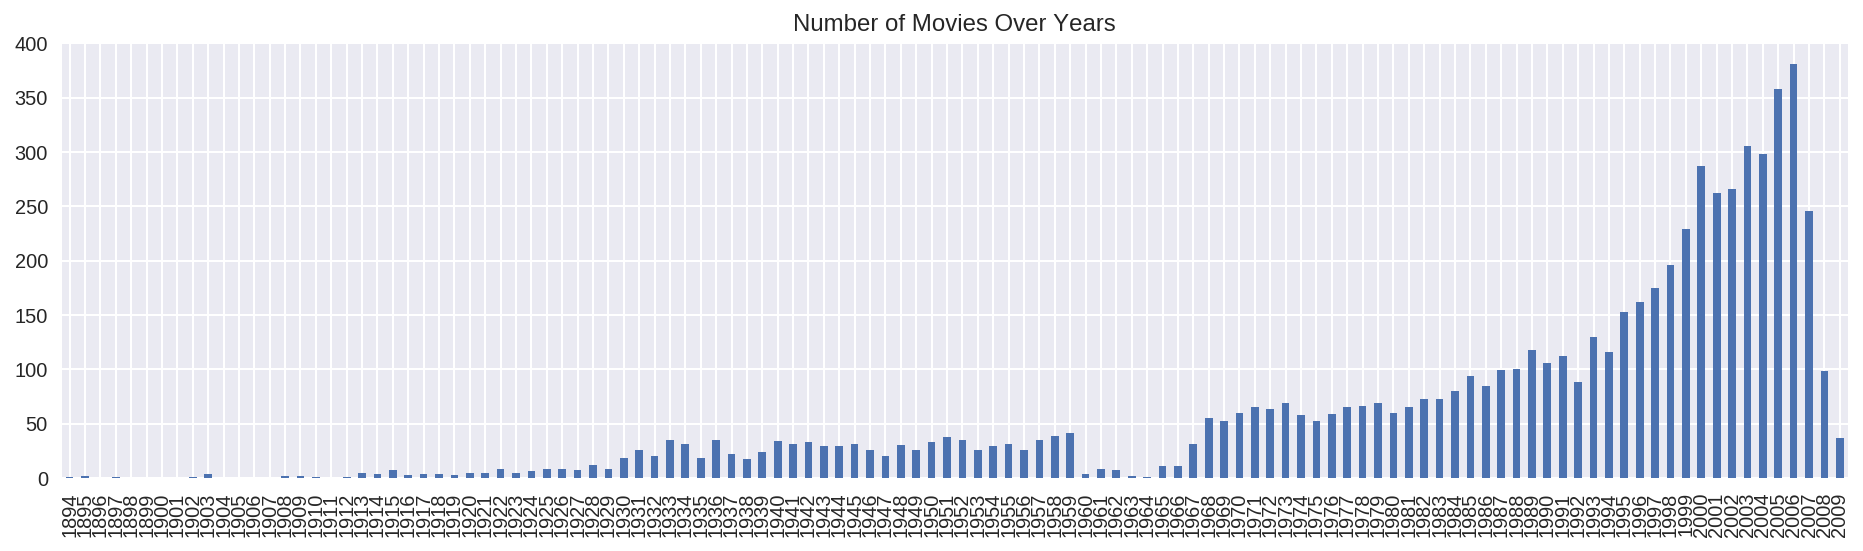

In [8]:
plt.figure(figsize=(16, 4))

dft = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(dft.index.min(), dft.index.max())).fillna(0)
dft.plot(kind='bar')
plt.title('Number of Movies Over Years')
plt.show()

Data contains movies released from 1894 until 2009. A lot of movies have been released in past years, particularly in 2006 number of released movies rocketed up to 381. Then it suddenly decreased or the author of the paper did not collect movie data for the recent years (note that the paper was published in 2011). Maybe the release of movies suddenly decreased due to the economic crisis that happened in 2008. Ok, it is not our focus, for now, let's move on :).

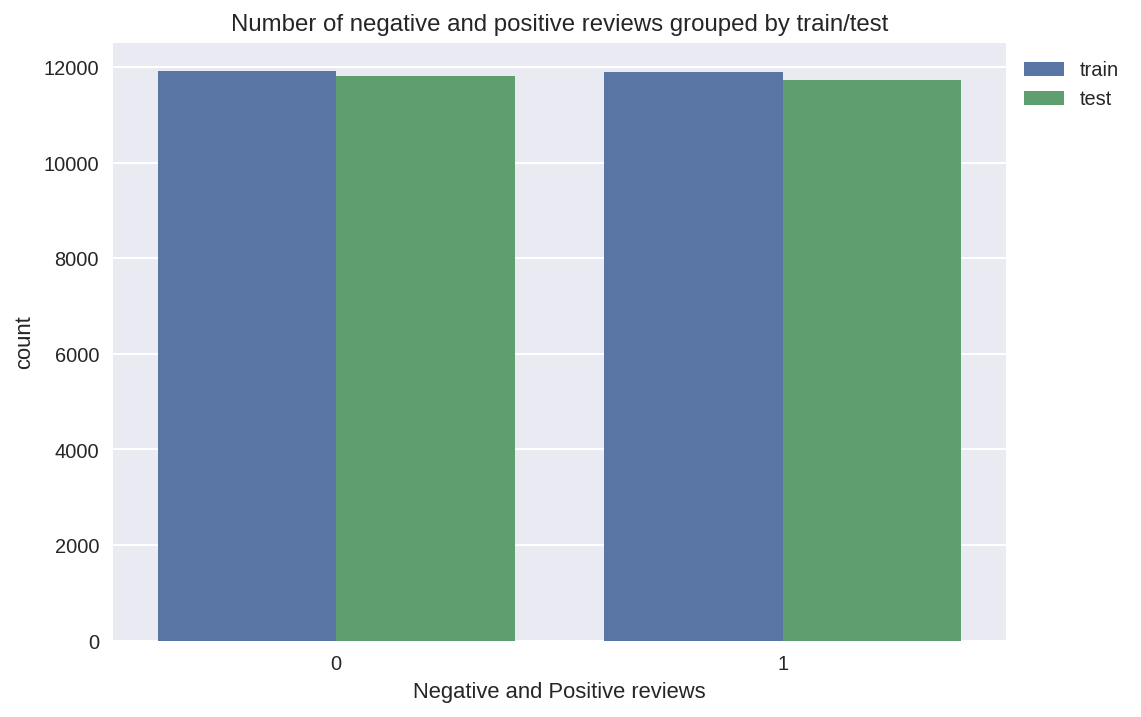

In [9]:
#explore data balance
sns.countplot(data=df_reviews, x='pos', hue='ds_part')
plt.title('Number of negative and positive reviews grouped by train/test')
plt.xlabel('Negative and Positive reviews')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

The data is balanced, it has similar number of positive and negative reviews for both training and testing datasets.

In [10]:
# check the number of positive and negative reviews (class imbalance)
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

### Conclusion
Data contains movies released from 1894 until 2009. Number of movies released per year increasing, particularly in 2006 number of released movies rocketed up to 381. Both datasets (training and testing) have similar number of negative and positive reviews. So, our data is balanced, we don't need to worry about class imbalance in our future models.

## Prepare data for modeling

### Functions

Composing an functions (cleaning text, lemmatize, evaluation routine) which can be used for all models in this project

In [11]:
def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    words = re.sub(pattern, " ", text)
    word_list = words.split()
    new_text = " ".join(word_list)
    new_text = new_text.lower()
    return new_text

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 4)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Clean the text

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
#remove all unnecassary charactres other than letters and apost.
df_reviews["review_clean"] = df_reviews["review"].progress_apply(clear_text)

In [15]:
#print result for comparison
print('='*20 + 'before cleaning' + "="*20)
print(df_reviews.review[7])
print()
print('='*20 + 'after cleaning' + "="*20)
print(df_reviews.review_clean[7])

====================before cleaning====================
This true story of Carlson's Raiders is more of a Army training film than anything else.Obviously thrown together quickly on a miniscule budget about the only thing it has to recommend it is an early performance by Robert Mitchum,who's the only decent actor in the cast,and actual footage of the wreckage at Pearl Harbor which gets your blood boiling,as it was obviously intended to do.

====================after cleaning====================
this true story of carlson's raiders is more of a army training film than anything else obviously thrown together quickly on a miniscule budget about the only thing it has to recommend it is an early performance by robert mitchum who's the only decent actor in the cast and actual footage of the wreckage at pearl harbor which gets your blood boiling as it was obviously intended to do


### Lemmatize the text

>Following cell will take around 10 min!

In [16]:
%%time
#convert words to their lemmas
df_reviews["review_lemma"] = df_reviews["review_clean"].progress_apply(lemmatize)


CPU times: user 5min 33s, sys: 1.45 s, total: 5min 34s
Wall time: 5min 47s


In [17]:
#check one row of the obtained data
df_reviews.review_lemma[7]

"this true story of carlson 's raider be more of a army training film than anything else obviously throw together quickly on a miniscule budget about the only thing -PRON- have to recommend -PRON- be an early performance by robert mitchum who be the only decent actor in the cast and actual footage of the wreckage at pearl harbor which get -PRON- blood boil as -PRON- be obviously intend to do"

### Feature and target prep

In [18]:
#split data into training and testing sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Check the shapes of two datasets
print(f'Shape of training set is {df_reviews_train.shape}.')
print(f'Shae of testing set is   {df_reviews_test.shape}.')

Shape of training set is (23796, 8).
Shae of testing set is   (23535, 8).


In [19]:
#prepare corpus
train_corpus = df_reviews_train['review_lemma']
test_corpus = df_reviews_test['review_lemma']

#define stop words and vectorizer
stop_words = stopwords.words('english')
tf_idf_vect = TfidfVectorizer(stop_words=stop_words)

#prepare features using vectorizer
X_train = tf_idf_vect.fit_transform(train_corpus)
X_test = tf_idf_vect.transform(test_corpus)


#prepare targets ('pos' column of the initial datasets)
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

#check the shapes of each variables
print(f'Shapes of training features and target are {X_train.shape} and {y_train.shape}, respectively')
print()
print(f'Shapes of testing features and target are  {X_test.shape} and  {y_test.shape}, respectively')

Shapes of training features and target are (23796, 60376) and (23796,), respectively

Shapes of testing features and target are  (23535, 60376) and  (23535,), respectively


### Conclusion
In this section, we have built several functions to preprocess our text data to make it ready for machine learning. First, we have removed everything else other than letters and apostrophes. Then we have obtained lemmas of words. Finally, we have prepared training and testing features (note: we have been already provided which rows should be for training and which rows should be used for testing) using TF-IDF vectorizer, which takes stop words argument from NLTK library to remove stop words.

## Training and test models
In this section, we will build several models based on different algorithms and train/test them, to check their various metrics. However, before that, to check the sanity of our models, we will build a constant model and compare our models to this constant model.

**NOTE**: we will not do hyperparameter tuning, because our data is so large and will be time-consuming. Therefore, we will use some default or random hyperparameters.

### Model 0 - Constant

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50
CPU times: user 349 ms, sys: 0 ns, total: 349 ms
Wall time: 389 ms


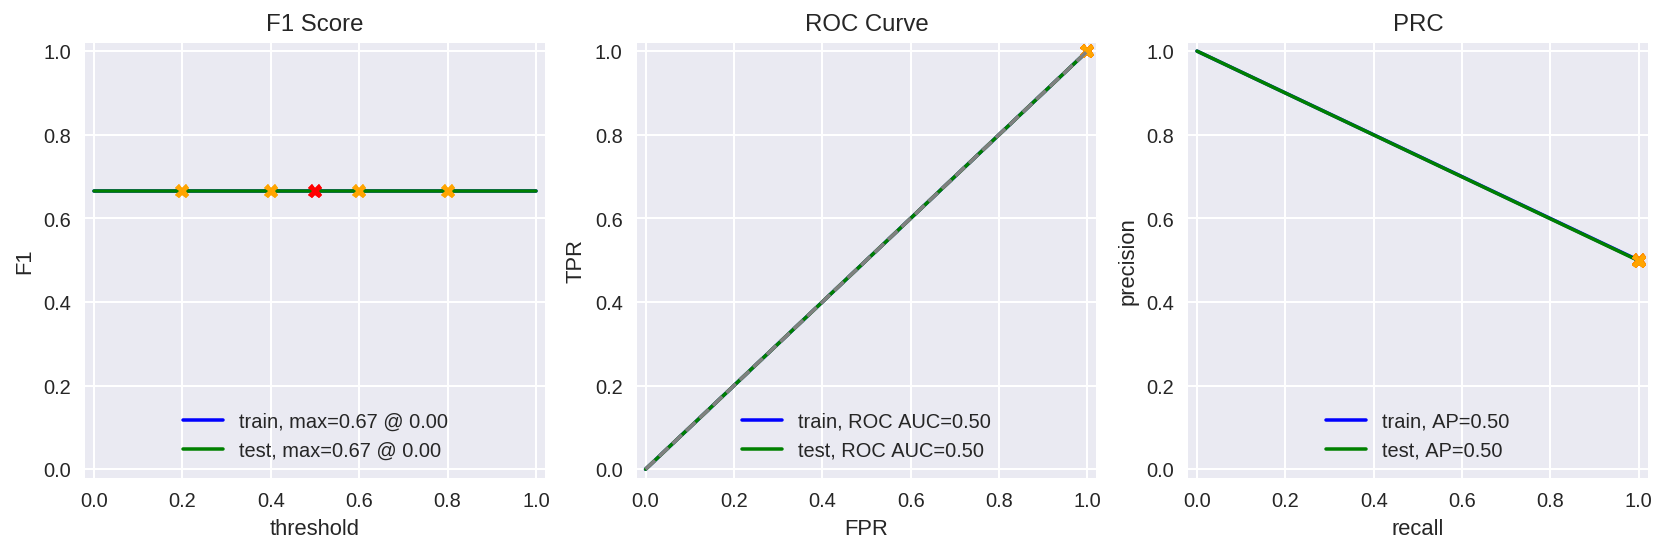

In [20]:
%%time
# dummy model which always predict a review as a positive (returns 1)
dummy_clf = DummyClassifier(strategy="constant", constant=1, random_state=234)
dummy_clf.fit(X_train, y_train)

#evaluate the model
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

Since our dataset is balanced (the number of positive and negative reviews were more or less equal), our dummy model has an accuracy of 0.5, which means such a model always guesses 50% of answers right. F1_score of the model is 0.67. So, our models should perform better than this in order to be acceptable.

### Model 1 -  LogisticRegression (LR)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 4.7 s, sys: 3.33 s, total: 8.03 s
Wall time: 8.06 s


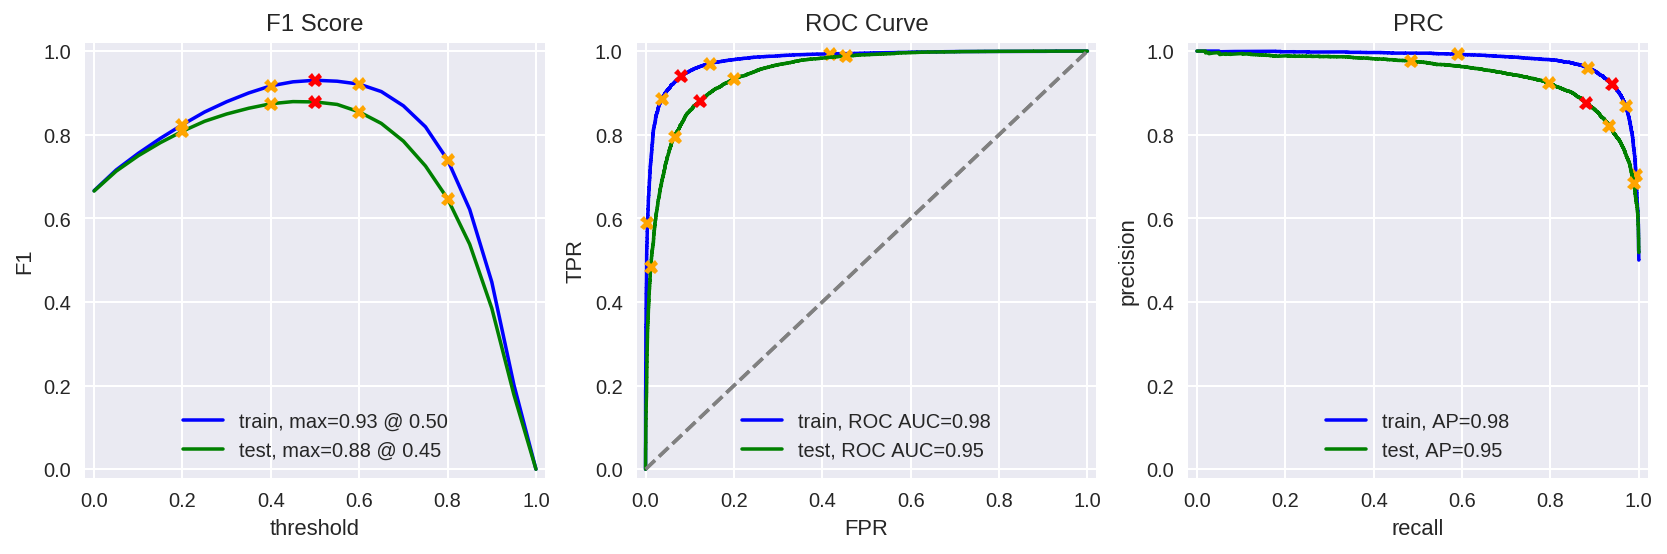

In [21]:
%%time

#build a model based on LogisticRegression algorithm
#since it does not have hyperparameter, we will use its defualt paramteres
lr_clf = LogisticRegression(solver='liblinear', random_state=2)
lr_clf.fit(X_train, y_train)

#check the metrics
evaluate_model(lr_clf, X_train, y_train, X_test, y_test)

The LogisticRegression model has an accuracy of 0.88, which is way better than the constant model. Moreover, F1_score, which is 0.88 here, also exceeds the requirements of the task (remember that F1_score should be at least 0.85 according to the description of the project).

### Model 2 - RandomForest (rf)

          train  test
Accuracy   0.99  0.85
F1         0.99  0.85
APS        1.00  0.92
ROC AUC    1.00  0.92
CPU times: user 23.9 s, sys: 10.4 ms, total: 23.9 s
Wall time: 24.1 s


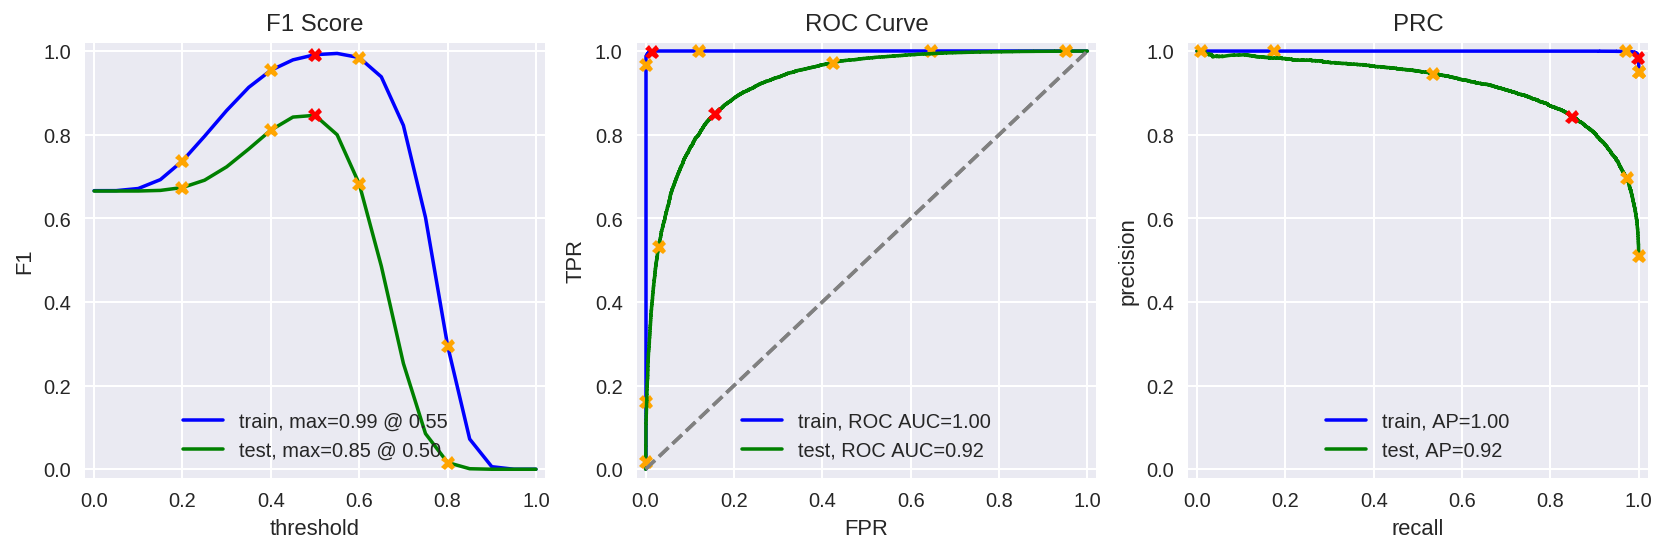

In [22]:
%%time
#construct a model based on RandomForest algorithm
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=234)
rf_clf.fit(X_train, y_train)

#check the metrics of the model
evaluate_model(rf_clf, X_train, y_train, X_test, y_test)

RandomForestclassifier is also better than the constant model and it achieved an accuracy of 0.85 and F1_score of 0.85. However, as you can see these scores with training data reaches to 0.99, and it barely reached to the 0.85 with testing set. This is a sign of model overfitting. Also, we can see from the plots, that curves of training and testing datasets differ a lot. However these values are better than default parameters of the model.

### Model 3 - Catboost (cb)

          train  test
Accuracy   0.88  0.85
F1         0.89  0.85
APS        0.95  0.93
ROC AUC    0.96  0.93
CPU times: user 1min 57s, sys: 3.65 s, total: 2min 1s
Wall time: 2min 2s


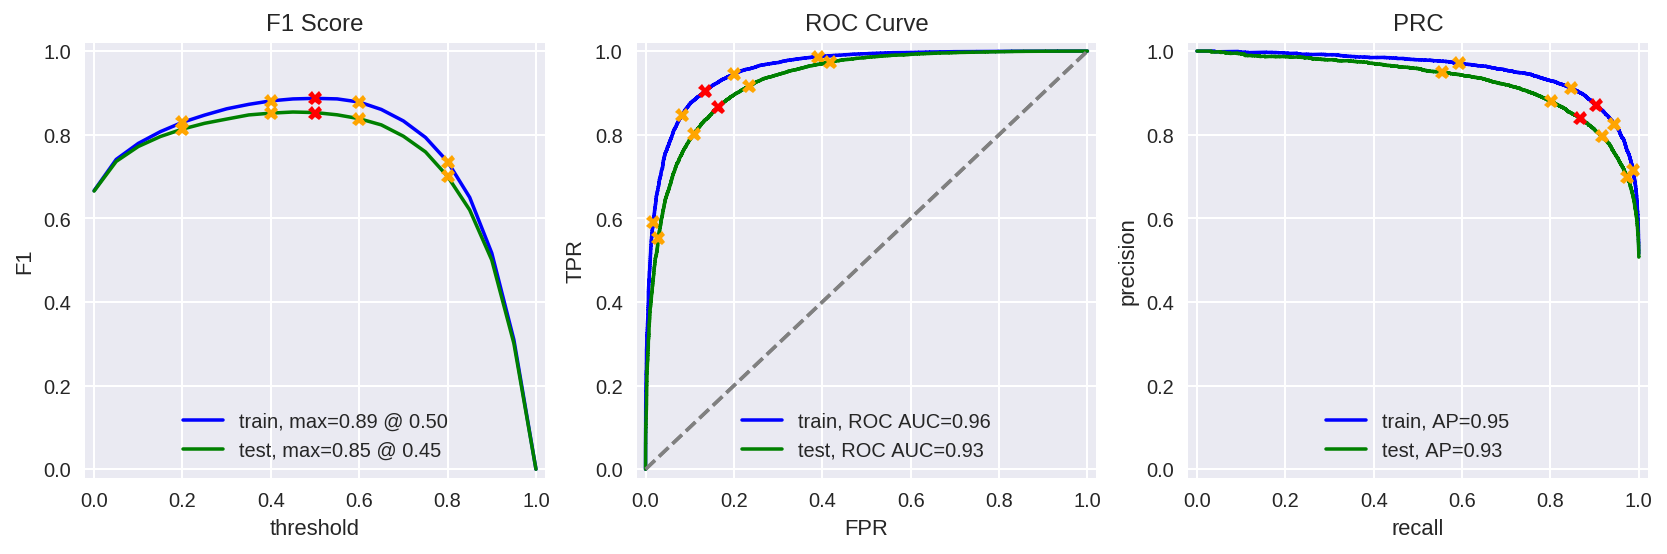

In [23]:
%%time

#define a model based on Catboost algo
cb_clf = CatBoostClassifier(iterations=50, verbose=False)
cb_clf.fit(X_train, y_train)

#check the metrics
evaluate_model(cb_clf, X_train, y_train, X_test, y_test)

Even though it is one of the slowest models, it was less overfitted compared to previous models. The catboost model reached an accuracy score of 0.85 and an F1_score of 0.85 as well. From the plots, we can see that the curves of training and testing data are very similar, which indicates the quite perfect fit of the model (neither overfit nor underfit).

### Conclusion

Three different models has been trained and tested with benchmarking performance with a constant model. Results are summarized in the table below:

|Model                  |Accuracy  |F1_score  |Time (seconds)|Remarks                        |
|-----------------------|----------|----------|--------------|---------------------------|
|DummyClassifier        |0.5       |0.67      |0.5           |Returns always 1               |
|LogisticRegression     |0.88      |0.88      |8.5           |Very quick                     |
|RandomForestClassifier |0.85      |0.85      |41            |Seems like overfitted          |
|CatBoostClassifier     |0.85      |0.85      |174           |Very slow, but less overfitted |


## My Reviews
Now we will create several our own reviews **(4 of them is positive and 4 of is negative)** and test our previous models.

In [24]:
#imaginary reviews 
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

#clean and lemmatize the reviews as before
my_reviews['review_clean'] = my_reviews['review'].apply(clear_text)
my_reviews['review_lemma'] = my_reviews['review_clean'].apply(lemmatize)

#vectorize the text
my_rew  = tf_idf_vect.transform(my_reviews['review_lemma'])
#
my_rew.shape

(8, 60376)

### Model 1 - LogReg

In [25]:
#call the previous model and predict
lr_pred = lr_clf.predict(my_rew)
lr_pred_prob = lr_clf.predict_proba(my_rew)[:, 1]

#print the results
print(f'{sum(lr_pred)} were predicted as positive out of {len(lr_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews.review.str.slice(0, 100)):
    print(f'  {lr_pred[i]}:   {lr_pred_prob[i]:.2f}:  {review}')

2 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  0:   0.27:  I did not simply like it, not my kind of movie.
  0:   0.08:  Well, I was bored and felt asleep in the middle of the movie.
  0:   0.44:  I was really fascinated with the movie
  0:   0.11:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  0:   0.24:  I didn't expect the reboot to be so good! Writers really cared about the source material
  1:   0.54:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.02:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.91:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 2 RandForest

In [26]:
#call the previous rf model and predict
rf_pred = rf_clf.predict(my_rew)
rf_pred_prob = rf_clf.predict_proba(my_rew)[:, 1]

#print the results
print(f'{sum(rf_pred)} were predicted as positive out of {len(rf_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews.review.str.slice(0, 100)):
    print(f'  {rf_pred[i]}:   {rf_pred_prob[i]:.2f}:  {review}')

6 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  1:   0.56:  I did not simply like it, not my kind of movie.
  1:   0.51:  Well, I was bored and felt asleep in the middle of the movie.
  1:   0.58:  I was really fascinated with the movie
  0:   0.48:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  1:   0.56:  I didn't expect the reboot to be so good! Writers really cared about the source material
  1:   0.55:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.39:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.68:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 3 - CatB

In [27]:
#call the previous cb model and predict
cb_pred = cb_clf.predict(my_rew)
cb_pred_prob = cb_clf.predict_proba(my_rew)[:, 1]

#print the results
print(f'{sum(cb_pred)} were predicted as positive out of {len(cb_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews.review.str.slice(0, 100)):
    print(f'  {cb_pred[i]}:   {cb_pred_prob[i]:.2f}:  {review}')

5.0 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  1.0:   0.62:  I did not simply like it, not my kind of movie.
  0.0:   0.49:  Well, I was bored and felt asleep in the middle of the movie.
  1.0:   0.57:  I was really fascinated with the movie
  0.0:   0.41:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  1.0:   0.68:  I didn't expect the reboot to be so good! Writers really cared about the source material
  1.0:   0.63:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0.0:   0.36:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1.0:   0.77:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Conlcusion
In total 8 synthetic reviews ( 4 positives and 4 negatives), were fed into three different models. The logistic regression model predicted only 2 of them as positive and however could not detect the two other positives. Contrary to this, the RandomForest model predicted 6 reviews as positive. As we already said that, the RandomForest model is a bit overfitted and that is why it is detecting some negative reviews as positive.
Our Catboost model predicted 5 as positive, which was very close to reality. It only detected one negative review as positive (false positive).

## Summary

1. Data with 47331 rows have been imported. Since not all columns of data are in focus of our interest, we have selected only interested columns (selected columns 'tconst', 'start_year', 'review', 'pos', 'ds_part', 'idx').

2. Since Data does not contain missing values, data type errors, and duplicated rows, we have not done preprocessing to the data.

3. From EDA, it was observed that data contains movies released from 1894 until 2009. Number of movies released per year increasing, particularly in 2006 number of released movies rocketed up to 381. Both datasets (training and testing) have similar number of negative and positive reviews, or data was balanced.

4. Text preprocessing steps: First, we have removed everything else other than letters and apostrophes. Then we have obtained lemmas of words. Finally, we have prepared training and testing features (note: we have been already provided which rows should be for training and which rows should be used for testing) using TF-IDF vectorizer, while removing stop words.

5. Three different models has been trained and tested with benchmarking their performance with a constant model. Results are summarized in the table below:

|Model                  |Accuracy  |F1_score  |Time (seconds)|Remarks                        |
|-----------------------|----------|----------|--------------|---------------------------|
|DummyClassifier        |0.5       |0.67      |0.5           |Returns always 1               |
|LogisticRegression     |0.88      |0.88      |8.5           |Very quick                     |
|RandomForestClassifier |0.85      |0.85      |41            |Seems like overfitted          |
|CatBoostClassifier     |0.85      |0.85      |174           |Very slow, but less overfitted |

6. In the last step, 8 synthetic reviews ( 4 positives and 4 negatives) were fed into previous models.
    - The logistic regression model predicted only 2 of them as positive and however could not detect the two other positives. 
    - The RandomForest model predicted 6 reviews as positive. As we already said that, the RandomForest model is a bit overfitted and that is why it is detecting some negative reviews as positive. 
    - The Catboost model predicted 5 as positive, which was very close to reality. It only detected one negative review as positive (false positive).
    
**As a summary, to automatically detect tonality of reviews, we can use Catboost model for high accuracy.**

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions